In [ ]:
from argparse import Namespace

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd
import seaborn as sns
# import torch
# from torch import Tensor
# from tqdm import tqdm
import os
import io
import glob
import sklearn
import nilearn as nl
from sklearn.manifold import TSNE
from nilearn.masking import apply_mask
from nilearn.image import index_img
import re
from nilearn import masking
from nilearn.input_data import NiftiMasker
from sklearn.cluster import KMeans
from csv import writer
from csv import reader 
from scipy.spatial import distance_matrix
from numpy import genfromtxt
import dask.dataframe as dd
import dask.array as da
from scipy.spatial import distance
import gc
from scipy.spatial.distance import cdist
from dask import compute, delayed
import dask
import  dask_ml
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import RBFSampler
from sklearn import random_projection
from sklearn.random_projection import johnson_lindenstrauss_min_dim

Matrix transformation

In [ ]:


file= open("/media/dataanalyticlab/Drive2/MANSOOR/Dataset/OpenBHB/Validation_set/val_set_openbhb.csv")
X_val_set = np.loadtxt(file, delimiter=",", usecols=np.arange(1,3659573))

roi_train = pd.read_csv("/media/dataanalyticlab/Drive2/MANSOOR/Dataset/OpenBHB/openbhb_train_roi_dataset.csv", header=None, usecols=np.arange(1,1797))

######## RBF sampler (random Fourier features)   #####################

# rbf_feature = RBFSampler(gamma=1, n_components=500)
# rbf_feature.fit(X_val_set)
# X_val_reduced = rbf_feature.transform(X_val_set)
# X_val_reduced = pd.DataFrame(X_val_reduced)
# X_val_reduced.to_csv("/media/dataanalyticlab/Drive2/MANSOOR/Dataset/OpenBHB/Validation_set/reduced_kernel_trick_openbhb_val_set_500_components.csv")

# X_val_reduced.to_numpy("/media/dataanalyticlab/Drive2/MANSOOR/Dataset/OpenBHB/Validation_set/reduced_kernel_trick_openbhb_val_set_500_components.npy")

#########  PCA-based transformations #######################

# data scaling
# X_val_scaled = StandardScaler().fit_transform(X_val_set)
# print("Matrix scaled")
# del X_val_set
# gc.collect()

pca = PCA(n_components=500)
 
X_val_pca_features = pca.fit_transform(X_val_scaled)
X_val_pca_features.to_csv("/media/dataanalyticlab/Drive2/MANSOOR/Dataset/OpenBHB/Reduced_matrices_openbhb/reduced_pca_openbhb_val_set_1000_components.csv")


########### JL transform #################

ROI_features = np.array(roi_train)
n = len(ROI_features)
# calculate mininimum number of random projection required by JL
min_dim = johnson_lindenstrauss_min_dim(n_samples=n, eps=0.1)
##### min_dim = 1379
# perform random projection
transformer = random_projection.GaussianRandomProjection(n_components=min_dim)
JL_transformed_roi_data = transformer.fit_transform(ROI_features)
print("Shape After Transformation: ",JL_transformed_roi_data.shape)
#print("Data transformed, now saving reduced data!!!")
np.save("/media/dataanalyticlab/Drive2/MANSOOR/Dataset/OpenBHB/Reduced_matrices_openbhb/ROI_JL_transformed_openbhb_train.npy", JL_transformed_roi_data)



Compute distance and covariance matrices

In [ ]:
euc_dist_mat_3209x3209 = np.zeros((3209,3209))
cos_dist_mat_3209x3209 = np.zeros((3209,3209))
cov_mat_3209x3209 = np.zeros((3209,3209))


In [ ]:
no_of_blocks = 13
rows = 250
skip_rows = 0
chunks = 10

In [ ]:
for i in range(6,no_of_blocks):
    rows = 250
    chunks = 10
    skip_rows = rows * i
    low_limit = rows * i
    if i==12:
        chunks=11
        rows = 209
        upper_limit = 209
    file = open(file_name)
    # load the ith diagonal data block
    data_mat_block_i = np.loadtxt(file ,delimiter = ",", usecols=np.arange(1,3659573), max_rows=rows, skiprows=skip_rows)
    # compute and store the distances and covariance blocks at the diagonals
    euc_dist_mat_3209x3209[low_limit:low_limit+rows, skip_rows:rows+skip_rows]= euclidean_dist_compute(data_mat_block_i, data_mat_block_i, chunks)
    cos_dist_mat_3209x3209[low_limit:low_limit+rows, skip_rows:rows+skip_rows]= cosine_dist_compute(data_mat_block_i, data_mat_block_i, chunks)
   
    cov_mat_3209x3209[low_limit:low_limit+rows, skip_rows:rows+skip_rows] = np.cov(data_mat_block_i)
    file.close()

    for j in range(i+1,no_of_blocks): # loop till all upper triangular blocks are computed
        skip_rows = skip_rows + rows
        upper_limit = rows
        if j==12:
            rows = 209
            chunks=11
            upper_limit = 250
        else:
            rows=250
            chunks=10
        file = open(file_name)
        data_mat_block_j = np.loadtxt(file ,delimiter = ",", usecols=np.arange(1,3659573), max_rows=rows, skiprows=skip_rows)
        file.close()
        # compute and store the distances and covariance blocks in the upper triangle
        euc_dist_mat_3209x3209[low_limit:low_limit+upper_limit, skip_rows:rows+skip_rows]= euclidean_dist_compute(data_mat_block_i, data_mat_block_j, chunks)
        cos_dist_mat_3209x3209[low_limit:low_limit+upper_limit, skip_rows:rows+skip_rows]= cosine_dist_compute(data_mat_block_i, data_mat_block_j, chunks)
        cov_mat_ij= np.cov(data_mat_block_i, data_mat_block_j)
        cov_mat_3209x3209[low_limit:low_limit+upper_limit, skip_rows:rows+skip_rows] = cov_mat_ij[0:upper_limit, upper_limit:rows+upper_limit]
        
    np.savetxt("/media/dataanalyticlab/Drive2/MANSOOR/Dataset/Dist_Cov_Matrices_OpenBHB/Euclidean_Dist_Mat_OpenBHB.csv", euc_dist_mat_3209x3209, delimiter=",")
    np.savetxt("/media/dataanalyticlab/Drive2/MANSOOR/Dataset/Dist_Cov_Matrices_OpenBHB/Cosine_Dist_Mat_OpenBHB.csv", cos_dist_mat_3209x3209, delimiter=",")
    np.savetxt("/media/dataanalyticlab/Drive2/MANSOOR/Dataset/Dist_Cov_Matrices_OpenBHB/Covariance_Mat_OpenBHB.csv", cov_mat_3209x3209, delimiter=",")     
    


In [ ]:
# read the computed upper triangluar matrix and save it in a full matrix
def save_full_mat(r_filename, s_filename):
    dist = pd.read_csv('/media/dataanalyticlab/Drive2/MANSOOR/Dataset/Dist_Cov_Matrices_OpenBHB/' +str(r_filename)+ '.csv', header=None)
    u_tri_mat = np.triu(dist)
    l_tri_mat = np.tril(u_tri_mat.transpose(), k=-1)
    s_filename = u_tri_mat + l_tri_mat
    np.savetxt("/media/dataanalyticlab/Drive2/MANSOOR/Dataset/Dist_Cov_Matrices_OpenBHB/" + str(s_filename) + ".csv", s_filename, delimiter=",")

In [ ]:
def euclidean_dist_compute(x, y, chunks):
    """Implementation using array concatenation"""
    values = [delayed(cdist)(x, xi, 'euclidean')
              for xi in np.split(y, chunks)]
    return np.concatenate(compute(*values, scheduler='threads'),
                          axis=1)

In [ ]:
def cosine_dist_compute(x, y, chunks):
    """Implementation using array concatenation"""
    values = [delayed(cdist)(x, xi, 'cosine')
              for xi in np.split(y, chunks)]
    return np.concatenate(compute(*values, scheduler='threads'),
                          axis=1)

In [ ]:
def corr_mat_compute(x, y, chunks):
    """Implementation using array concatenation"""
    values = [delayed(cdist)(x, xi, 'correlation')
              for xi in np.split(y, chunks)]
    return np.concatenate(compute(*values, scheduler='threads'),
                          axis=1)

In [ ]:
def cov_mat_compute(x, y, chunks):
    """Implementation using array concatenation"""
    values = [delayed(np.cov)(x, y)]
    return np.concatenate(compute(*values, scheduler='threads'),
                          axis=1)

<Figure size 1000x500 with 0 Axes>

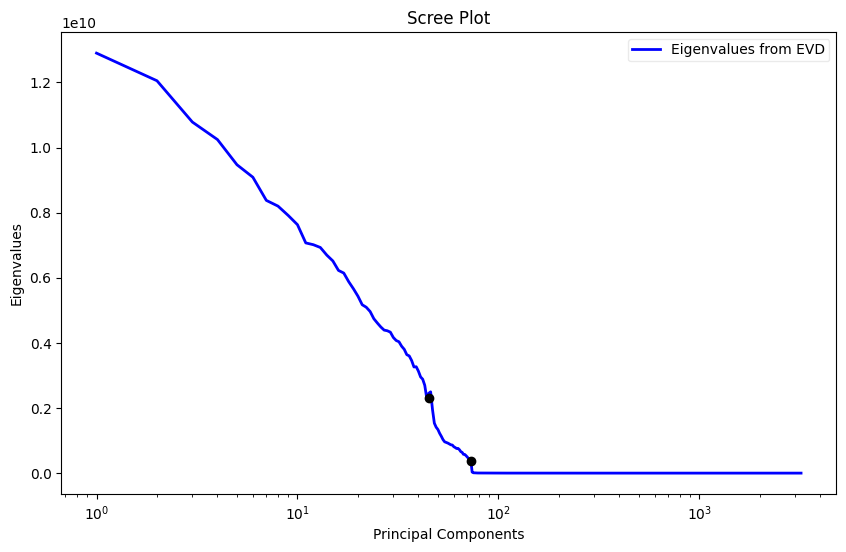

In [ ]:
############## Find EVD of the covariance matrix  ##################### 

cov_mat = pd.read_csv('/media/dataanalyticlab/Drive2/MANSOOR/Dataset/Dist_Cov_Matrices_OpenBHB/Full_matrices/Cov_mat_openbhb_full.csv', header=None)
D,Q = np.linalg.eig(cov_mat)

fig = plt.figure(figsize=(10,5))
eigen_values=D**2/np.sum(D**2)
figure=plt.figure(figsize=(10,6))
# plt.axes.Axes.set_xscale(1, 'linear')
# fig.xaxis.set_ticklabels([0, 10,50,100,500,1000,2000,3000,3200])
# fig.xaxis.set_ticks([0, 10,50,100,500,1000,2000,3000,3200])
sing_vals=np.arange(3207) + 1
plt.plot(sing_vals,D[2:3210], 'b', linewidth=2)
plt.yscale("linear")
plt.xscale("log")

plt.title('Scree Plot')
plt.xlabel('Principal Components')
plt.ylabel('Eigenvalues')
leg = plt.legend(['Eigenvalues from EVD'], loc='best', borderpad=0.3, 
                 shadow=False,
                 markerscale=0.4)
leg.get_frame().set_alpha(0.4)

plt.plot(45,2303245684.010627, 'o', color='black')
plt.plot(73,366789333.1492814, 'o', color='black')

# plt.show()
plt.savefig('/media/dataanalyticlab/Drive2/MANSOOR/Dataset/OpenBHB/EDA/Scree_plot_pca_openbhb.png')